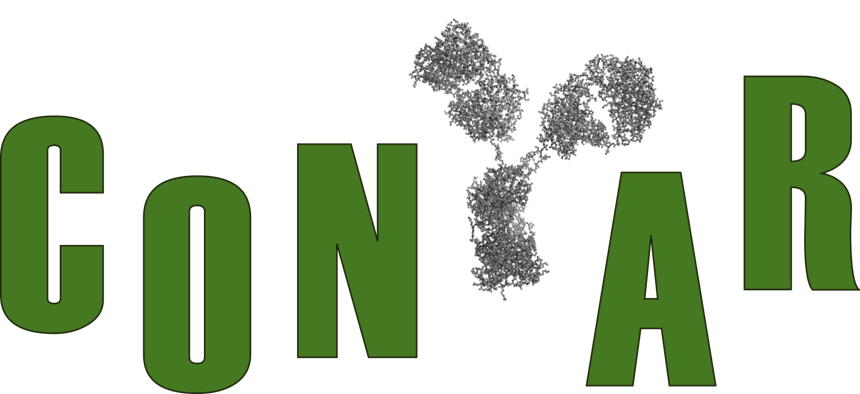

In [1]:
from IPython.display import display, Image
display(Image(filename='CONYAR_Logo_s.png'))

# **CONYAR** - **CON**served **Y**ou **AR**e
### An easy tool to find conserved regions in proteins

### CONYAR is splitted into **four** main components:

1. **CONYAR_Collector**  
   _The Collector fetches the data from the UniProtKB_    
     
   1. **CONYAR_Filter**  
   _The Filter is a submodule of the Collector and filters the incomming data from the UniProtKB_  
          <BR>
2. **CONYAR_Aligner**  
   _The aligner conducts the MSA using Clustal Omega_  
     
   1. **CONYAR_FASTA**  
   _FASTA converts the collected aminoacid sequences into the FASTA format_  
      <BR>       
3. **CONYAR_Finder**  
   _The Finder uses the alignment data and extracts the conserved regions_       
     
4. **CONYAR_Presentor**  
   _The Presentor generates the final report PDF with the graphical representation of the alignment results and the conserved regions as sequence logo diagram_  



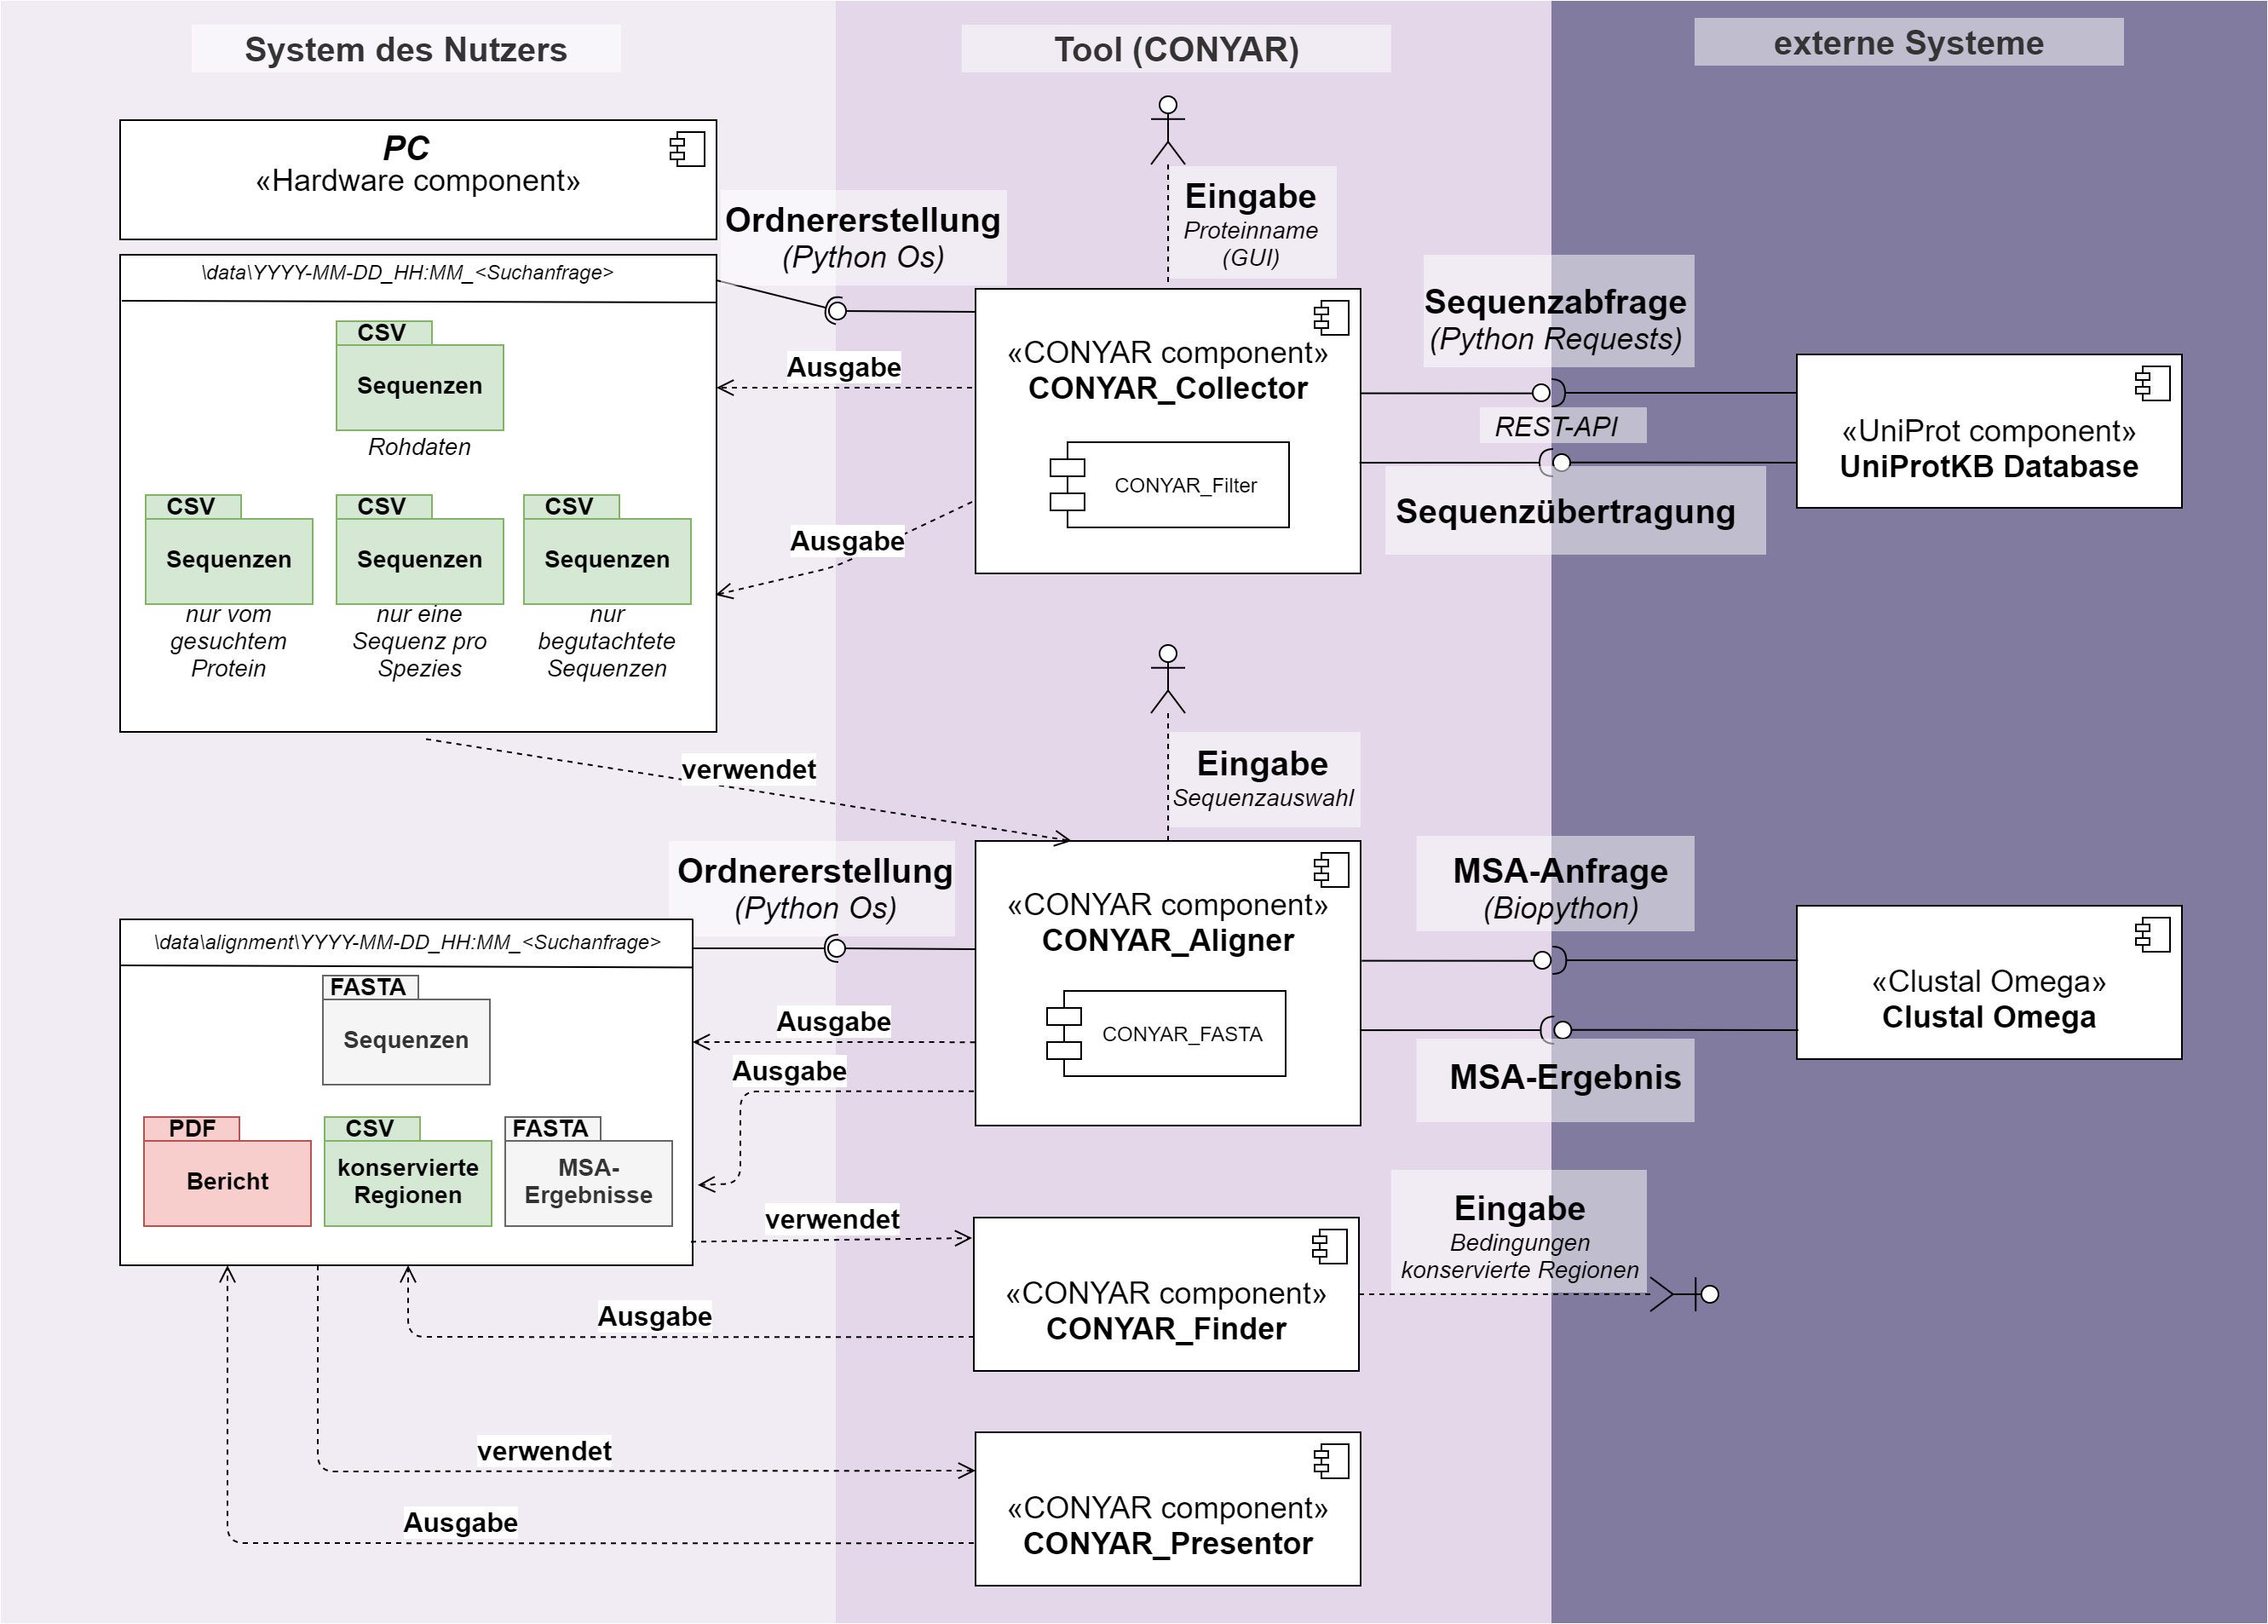

In [2]:
display(Image(filename='UML_Komponenten.png'))

### Install all necessary packages for python

In [ ]:
#As wrapper for Clustal Omega Alignment and to handle Multiple Sequence Alignments
pip install biopython

#To request data from Website API
pip install requests

#To handle data in DataFrames
pip install pandas

#To use R functions in python
pip install rpy2

#To generate results pdf

pip install FPDF

### Component 1 - CONYAR_Collector

#### _Fetches data from UniProt_


**Tutorial: Programmatic access to UniProt using Python**

https://www.ebi.ac.uk/training/events/programmatic-access-uniprot-using-python/ 

(DOI: 10.6019/TOL.UniProtPython-w.2021.00001.1)

**Colab Notebook**

https://colab.research.google.com/drive/1SU3j4VmXHYrYxOlrdK_NCBhajXb0iGes#scrollTo=zvDpOjPwgQoP

In [21]:
import requests, sys, json
import pandas as pd
from datetime import datetime
import os 

In [ ]:
WEBSITE_API = "https://rest.uniprot.org/uniprotkb"

# Helper function to download data
def get_url(url, **kwargs):
  response = requests.get(url, **kwargs);
  
  if not response.ok:
    print(response.text)
    response.raise_for_status()
    sys.exit()

  return response

In [ ]:
#input query name (protein of interest)
poi_name = str(input("Enter gene name of protein of interest"))
query = "/stream?query="+poi_name

In [ ]:
#generates string with time stamp
date_time = datetime.now()
date = date_time.strftime("%Y-%m-%d_%Hh%Mmin")

In [ ]:
#generates folder for data
directory = date+"_"+poi_name
cwd = os.getcwd()
parent_dir = cwd+'\data'
dir_path = os.path.join(parent_dir, directory) 
os.mkdir(dir_path)

In [ ]:

#requests data from UniProtKB and saves it as JSON file

with open("q_results_"+poi_name+".json", "w") as write_file:
    json.dump(data, write_file)
q_results = get_url(f"{WEBSITE_API}"+query)
data = q_results.json()
#prints number of query results
total = len(data["results"])
print(f"total: {total}")
with open("data/"+date+"_"+poi_name+"/01_q_results_"+poi_name+".json", "w") as write_file:
    json.dump(data, write_file)

### Component 1 - CONYAR_Collector
### Subcomponent - CONYAR_Filter  

#### _Filters the UniProtKB data and saves the results as CSV files_

In [ ]:
#function to filter JSON file

def filtering(object,keys):
    ioi = {} 
    for path in keys:
        paths = path.split(".")
        rec=''
        origin = object
        target = ioi
        for key in paths: 
            rec += key
            if key in target:
                target = target[key]
                origin = origin[key]
                rec += '.'
                continue
            if key in origin:
                if rec == path:
                    target[key] = origin[key]
                else:
                    target[key] = {}
                target = target[key]
                origin = origin[key]
                rec += '.'
            else:
                target[key] = None
                break
    return ioi


In [ ]:
#function to flatten JSON file
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

In [ ]:
#filtering and flattening of original JSON file
f = open("data/"+date+"_"+poi_name+"/01_q_results_"+poi_name+".json")
data = json.load(f)

filtered_flatened_data = []
needed_entries = ['entryType', 'primaryAccession', 'annotationScore', 'organism', 'genes', 'sequence']

for entry in data['results']: 
     filtered_entry = filtering(entry,  needed_entries)
     filtered_flatened_data.append(flatten_json(filtered_entry))

with open("data/"+date+"_"+poi_name+"/02_filtered_flatened_"+poi_name+".json", "w") as write_file:
    json.dump(filtered_flatened_data, write_file)

In [ ]:
#generation of Pandas DataFrame from JSON
df_filtered_flatened = pd.DataFrame.from_dict(filtered_flatened_data)

query_results = df_filtered_flatened[['entryType', 'primaryAccession', 'annotationScore', 'organism_scientificName', 'organism_commonName', 'organism_taxonId', 'genes_0_geneName_value', 'sequence_value', 'sequence_length', 'sequence_molWeight']]
query_results.rename(columns = {'organism_scientificName':'scientificName', 'organism_commonName':'commonName', 'organism_taxonId':'taxonId','genes_0_geneName_value':'geneName', 'sequence_value':'sequence', 'sequence_molWeight':'molWeight'}, inplace = True)

query_results_2 = query_results
query_results_2[['entryType','primaryAccession', 'scientificName','commonName','sequence','geneName']] = query_results[['entryType', 'primaryAccession', 'scientificName','commonName','sequence','geneName']].astype(str)
#save DataFrame as CSV
query_results_2.to_csv("data/"+date+"_"+poi_name+"/03_raw_data_"+poi_name+'.csv',sep=';')

In [ ]:
#only keep entries with the input gene name as gene name
query_results_2.dropna(subset=['geneName'])
only_poi = query_results_2[query_results_2['geneName'].str.contains(poi_name, case=False)].reset_index(drop=True)
#save new DataFrame as CSV
only_poi.to_csv("data/"+date+"_"+poi_name+"/04_all_entries_"+poi_name+'.csv',sep=';')

In [ ]:
#only keep the entry with the highest annotation score and sequence length for every species (taxon ID)
only_poi_sorted = only_poi.sort_values(by=['taxonId','annotationScore', 'sequence_length'], ascending=False)
only_poi_unique = only_poi_sorted.drop_duplicates(subset=['taxonId'], keep='first').reset_index(drop=True)
#save new DataFrame as CSV
only_poi_unique.to_csv("data/"+date+"_"+poi_name+"/05_final_filtered_"+poi_name+'.csv',sep=';')

In [ ]:
#only keep entries of reviewed sequences
only_poi_2 = only_poi[-only_poi['entryType'].str.contains('unreviewed')].reset_index(drop=True)
#save new DataFrame as CSV
only_poi_2.to_csv("data/"+date+"_"+poi_name+"/06_only_reviewed_"+poi_name+'.csv',sep=';')
f.close()

### Component 1 - CONYAR_Collector + CONYAR_Filter
### _Complete clean code_

In [ ]:
import requests, sys, json
import pandas as pd
import os 
from datetime import datetime

WEBSITE_API = "https://rest.uniprot.org/uniprotkb"

def get_url(url, **kwargs):
  response = requests.get(url, **kwargs);

  if not response.ok:
    print(response.text)
    response.raise_for_status()
    sys.exit()

  return response

poi_name = str(input("Enter gene name of protein of interest"))
query = "/stream?query="+poi_name

date_time = datetime.now()
date = date_time.strftime("%Y-%m-%d_%Hh%Mmin")

directory = date+"_"+poi_name
cwd = os.getcwd()
parent_dir = cwd+'\data'
dir_path = os.path.join(parent_dir, directory) 
os.mkdir(dir_path)

q_results = get_url(f"{WEBSITE_API}"+query)
data = q_results.json()

with open("data/query_results/"+date+"_"+poi_name+"/"+date+"_q_results_"+poi_name+".json", "w") as write_file:
    json.dump(data, write_file)
 
def filtering(object,keys):
    ioi = {} 
    for path in keys:
        paths = path.split(".")
        rec=''
        origin = object
        target = ioi
        for key in paths: 
            rec += key
            if key in target:
                target = target[key]
                origin = origin[key]
                rec += '.'
                continue
            if key in origin:
                if rec == path:
                    target[key] = origin[key]
                else:
                    target[key] = {}
                target = target[key]
                origin = origin[key]
                rec += '.'
            else:
                target[key] = None
                break
    return ioi

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

f = open("data/"+date+"_"+poi_name+"/01_q_results_"+poi_name+".json")
data = json.load(f)

filtered_flatened_data = []
needed_entries = ['entryType', 'primaryAccession', 'annotationScore', 'organism', 'genes', 'sequence']

for entry in data['results']: 
     filtered_entry = filtering(entry,  needed_entries)
     filtered_flatened_data.append(flatten_json(filtered_entry))

with open("data/"+date+"_"+poi_name+"/02_filtered_flatened_"+poi_name+".json", "w") as write_file:
    json.dump(filtered_flatened_data, write_file)

df_filtered_flatened = pd.DataFrame.from_dict(filtered_flatened_data)

query_results = df_filtered_flatened[['entryType', 'primaryAccession', 'annotationScore', 'organism_scientificName', 'organism_commonName', 'organism_taxonId', 'genes_0_geneName_value', 'sequence_value', 'sequence_length', 'sequence_molWeight']]
query_results.rename(columns = {'organism_scientificName':'scientificName', 'organism_commonName':'commonName', 'organism_taxonId':'taxonId','genes_0_geneName_value':'geneName', 'sequence_value':'sequence', 'sequence_molWeight':'molWeight'}, inplace = True)

query_results_2 = query_results
query_results_2[['entryType','primaryAccession', 'scientificName','commonName','sequence','geneName']] = query_results[['entryType', 'primaryAccession', 'scientificName','commonName','sequence','geneName']].astype(str)
query_results_2.to_csv("data/"+date+"_"+poi_name+"/03_raw_data_"+poi_name+'.csv',sep=';')

query_results_2.dropna(subset=['geneName'])
only_poi = query_results_2[query_results_2['geneName'].str.contains(poi_name, case=False)].reset_index(drop=True)
only_poi.to_csv("data/"+date+"_"+poi_name+"/04_all_entries_"+poi_name+'.csv',sep=';')

only_poi_sorted = only_poi.sort_values(by=['taxonId','annotationScore', 'sequence_length'], ascending=False)
only_poi_unique = only_poi_sorted.drop_duplicates(subset=['taxonId'], keep='first').reset_index(drop=True)
only_poi_unique.to_csv("data/"+date+"_"+poi_name+"/05_final_filtered_"+poi_name+'.csv',sep=';')

only_poi_2 = only_poi[-only_poi['entryType'].str.contains('unreviewed')].reset_index(drop=True)
only_poi_2.to_csv("data/"+date+"_"+poi_name+"/06_only_reviewed_"+poi_name+'.csv',sep=';')

f.close()

### Component 2 - CONYAR_Aligner

#### _Uses Clustal Omega to perform MSA_  
  
### Subcomponent - CONYAR_FASTA  
  
#### _Transforms the sequence data from the Dataframe into the FASTA format_



In [10]:
#function to create FASTA files out of DataFrame
def fasta_creator(df, fasta):
    for i in range(len(df)-1):
       fasta.write('>['+df.iloc[i,1]+']\n')
       fasta.write(df.iloc[i,2]+'\n')
    fasta.close()

In [ ]:
#DataFrame for FASTA file creation
df_seq_list_1 = only_poi_unique[['taxonId','scientificName','sequence']]
df_seq_list = df_seq_list_1.applymap(str)

In [ ]:
#create FASTA file
seq_list_fasta = open("data/"+date+"_"+poi_name+"/07_sequences_"+poi_name+'.fasta','w+')
fasta_creator(df_seq_list,seq_list_fasta)

In [ ]:
#List of selected species (TaxonIDs)
list_of_taxonIDs = ['9606','9595','9597','9598','60711','10090','10116','9986','9031','28377','8665','8364','8355','7955','7227','3702','9913','9940','9925','9823','9615','9685']

df_seq_spec_taxons = df_seq_list[df_seq_list['taxonId'].isin(list_of_taxonIDs)].reset_index(drop=True)
df_seq_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/08_sequences_spec_taxons_"+poi_name+'.csv',sep=';')
seq_spec_taxons_fasta = open("data/"+date+"_"+poi_name+"/09_sequences_spec_taxons_"+poi_name+'.fasta','w+')
fasta_creator(df_seq_spec_taxons,seq_spec_taxons_fasta)

### Component 2 - CONYAR_Aligner

#### _Uses Clustal Omega to perform MSA_  

In [11]:
from Bio.Align.Applications import ClustalOmegaCommandline

#alignment of all sequences?
msa_settings = str(input("Enter ""full"" for an MSA of all species, otherwise the MSA is performed for a subset of species."))
if msa_settings == "full" or msa_settings == "Full":
    in_file = "data/"+date+"_"+poi_name+"/07_sequences_"+poi_name+'.fasta'
    out_file = "data/"+date+"_"+poi_name+"/10_aligned_sequences_"+poi_name+'.fasta'
    #path of clustal omega 
    clustalo_exe = cwd+r'\clustalo\clustalo.exe' 
    #MSA settings
    clustalomega_cline = ClustalOmegaCommandline(clustalo_exe, infile=in_file, outfmt="fasta", outfile=out_file, residuenumber=True, verbose=True, auto=True)
    stdout, stderr = clustalomega_cline()
else:
    in_file = "data/"+date+"_"+poi_name+"/09_sequences_spec_taxons_"+poi_name+'.fasta'
    out_file = "data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'
    clustalo_exe = cwd+r'\clustalo\clustalo.exe' 
    clustalomega_cline = ClustalOmegaCommandline(clustalo_exe, infile=in_file, outfmt="fasta", outfile=out_file, residuenumber=True, verbose=True, auto=True)
    stdout, stderr = clustalomega_cline()

### Component 2 - CONYAR_Aligner + CONYAR_FASTA
### _Complete clean code_

In [ ]:

def fasta_creator(df, fasta):
    for i in range(len(df)-1):
       fasta.write('>['+df.iloc[i,1]+']\n')
       fasta.write(df.iloc[i,2]+'\n')
    fasta.close()

df_seq_list_1 = only_poi_unique[['taxonId','scientificName','sequence']]
df_seq_list = df_seq_list_1.applymap(str)

seq_list_fasta = open("data/"+date+"_"+poi_name+"/07_sequences_"+poi_name+'.fasta','w+')
fasta_creator(df_seq_list,seq_list_fasta)

list_of_taxonIDs = ['9606','9595','9597','9598','60711','10090','10116','9986','9031','28377','8665','8364','8355','7955','7227','3702','9913','9940','9925','9823','9615','9685']

df_seq_spec_taxons = df_seq_list[df_seq_list['taxonId'].isin(list_of_taxonIDs)].reset_index(drop=True)
df_seq_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/08_sequences_spec_taxons_"+poi_name+'.csv',sep=';')

seq_spec_taxons_fasta = open("data/"+date+"_"+poi_name+"/09_sequences_spec_taxons_"+poi_name+'.fasta','w+')
fasta_creator(df_seq_spec_taxons,seq_spec_taxons_fasta)

from Bio.Align.Applications import ClustalOmegaCommandline

msa_settings = str(input("Enter ""full"" for an MSA of all species, otherwise the MSA is performed for a subset of species."))

if msa_settings == "full":
    in_file = "data/"+date+"_"+poi_name+"/07_sequences_"+poi_name+'.fasta'
    out_file = "data/"+date+"_"+poi_name+"/10_aligned_sequences_"+poi_name+'.fasta'
    clustalo_exe = cwd+r'\clustalo\clustalo.exe' 
    clustalomega_cline = ClustalOmegaCommandline(clustalo_exe, infile=in_file, outfmt="fasta", outfile=out_file, residuenumber=True, verbose=True, auto=True)
    stdout, stderr = clustalomega_cline()
else:
    in_file = "data/"+date+"_"+poi_name+"/09_sequences_spec_taxons_"+poi_name+'.fasta'
    out_file = "data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'
    clustalo_exe = cwd+r'\clustalo\clustalo.exe' 
    clustalomega_cline = ClustalOmegaCommandline(clustalo_exe, infile=in_file, outfmt="fasta", outfile=out_file, residuenumber=True, verbose=True, auto=True)
    stdout, stderr = clustalomega_cline()

### Component 3 - CONYAR_Finder

#### _Extracts the conserved regions from the MSA data_  

In [ ]:
from Bio import AlignIO
from Bio.Align import AlignInfo
#load alignment fasta file
align = AlignIO.read(open("aln_test.fasta"), "fasta")
#extracts information out of alignment data
summary_align = AlignInfo.SummaryInfo(align)
#finding the consensus sequences using the gap consensus method
# threshold = percentage of coverage
# amiguous = uncertain amino acid 
consensus_gap = summary_align.gap_consensus(threshold = 0.6, ambiguous='x')
#converting the whole consensus sequence to a string
string_consensus = str(consensus_gap)
#creating an empty DataFrame for consensus sequences and ther positions within the amino acid sequence
consensus_sequences_empty = pd.DataFrame(columns=['Start','End','Sequence'])

#function to filter all consensus sequences out of the whole consensus sequence
def create_consensus_df(df, con_str):
    start = -1
    end = -1
    con_seq = str('')
    con_seq_entry = []
    for count, value in enumerate(con_str):
        if value == '-' and start != count+1-len(con_seq):
            continue
        elif start != count+1-len(con_seq):
            start = count+1 
            con_seq += str(value)
            continue
        elif value == '-' and start == count+1-len(con_seq):
            end = count
            con_seq_entry = [start,end,con_seq]
            df.loc[len(df)] = con_seq_entry
            con_seq = str('')
            continue
        else:
            con_seq += str(value)
            continue
    return df

#input of minimal length of conserved regions and minimal coverage
#exceptions if the inputs do not meet the requirements
try:
    min_length_request = input("Enter the minimum length of a consensus sequence:")
    min_length = int(min_length_request)
except ValueError:
    min_length = int(3)
    print("The value for the minimum length has to be an integer. Therefore, the default minimal length of 3 was used")

try:
    threshold_request = input("Define minimum percentage of coverage for conserved regions (values from 0.1 to 1.0):")
    th = float(threshold_request)
except ValueError:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")    
if th > 1.0:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")
elif th < 0.1:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")

from Bio import AlignIO
from Bio.Align import AlignInfo

if msa_settings == "full":
    align = AlignIO.read(open("data/"+date+"_"+poi_name+"/10_aligned_sequences_"+poi_name+'.fasta'), "fasta")
    summary_align = AlignInfo.SummaryInfo(align)
    #create consensus sequence out of alignment data
    consensus_gap = summary_align.gap_consensus(threshold = th, ambiguous='x')
    string_consensus = str(consensus_gap)
    consensus_sequences_empty = pd.DataFrame(columns=['Start','End','Sequence'])
    consensus_sequences = create_consensus_df(consensus_sequences_empty, string_consensus)
    consensus_sequences.to_csv("data/"+date+"_"+poi_name+"/12_consensus_sequences_"+poi_name+'.csv',sep=';')
    consensus_sequences_length = consensus_sequences
    consensus_sequences_length['length'] = consensus_sequences['Sequence'].str.len()
    filtered_consensus_sequences = consensus_sequences_length[(consensus_sequences_length['Sequence'].str.contains('C')==True) | (consensus_sequences_length['length'] >= min_length)].reset_index(drop=True)
    filtered_consensus_sequences.to_csv("data/"+date+"_"+poi_name+"/13_filtered_consensus_sequences_"+poi_name+'.csv',sep=';')
else:
    align_spec_taxons = AlignIO.read(open("data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'), "fasta")
    summary_align_spec_taxons = AlignInfo.SummaryInfo(align_spec_taxons)
    consensus_gap_spec_taxons = summary_align_spec_taxons.gap_consensus(threshold = th, ambiguous='x')
    string_consensus_spec_taxons = str(consensus_gap_spec_taxons)
    consensus_sequences_spec_taxons_empty = pd.DataFrame(columns=['Start','End','Sequence'])

    consensus_sequences_spec_taxons = create_consensus_df(consensus_sequences_spec_taxons_empty, string_consensus_spec_taxons)

    consensus_sequences_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/14_consensus_sequences_spec_taxons_"+poi_name+'.csv',sep=';')

    consensus_sequences_spec_taxons_length = consensus_sequences_spec_taxons
    consensus_sequences_spec_taxons_length['length'] = consensus_sequences_spec_taxons['Sequence'].str.len()
    filtered_consensus_sequences_spec_taxons = consensus_sequences_spec_taxons_length[(consensus_sequences_spec_taxons_length['Sequence'].str.contains('C')==True) | (consensus_sequences_spec_taxons_length['length'] >= min_length)].reset_index(drop=True)
    filtered_consensus_sequences_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/15_filtered_consensus_sequences_spec_taxons_"+poi_name+'.csv',sep=';')

### Component 3 - CONYAR_Finder

#### _Complete clean code_  

In [ ]:
from Bio import AlignIO
from Bio.Align import AlignInfo

def create_consensus_df(df, con_str):
    start = -1
    end = -1
    con_seq = str('')
    con_seq_entry = []
    for count, value in enumerate(con_str):
        if value == '-' and start != count+1-len(con_seq):
            continue
        elif start != count+1-len(con_seq):
            start = count+1 
            con_seq += str(value)
            continue
        elif value == '-' and start == count+1-len(con_seq):
            end = count
            con_seq_entry = [start,end,con_seq]
            df.loc[len(df)] = con_seq_entry
            con_seq = str('')
            continue
        else:
            con_seq += str(value)
            continue
    return df

try:
    min_length_request = input("Enter the minimum length of a consensus sequence:")
    min_length = int(min_length_request)
except ValueError:
    min_length = int(3)
    print("The value for the minimum length has to be an integer. Therefore, the default minimal length of 3 was used")

try:
    threshold_request = input("Define minimum percentage of coverage for conserved regions (values from 0.1 to 1.0):")
    th = float(threshold_request)
except ValueError:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")    
if th > 1.0:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")
elif th < 0.1:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")

if msa_settings == "full":
    align = AlignIO.read(open("data/"+date+"_"+poi_name+"/10_aligned_sequences_"+poi_name+'.fasta'), "fasta")
    summary_align = AlignInfo.SummaryInfo(align)
    consensus_gap = summary_align.gap_consensus(threshold = th, ambiguous='x')
    string_consensus = str(consensus_gap)
    consensus_sequences_empty = pd.DataFrame(columns=['Start','End','Sequence'])
    consensus_sequences = create_consensus_df(consensus_sequences_empty, string_consensus)
    consensus_sequences.to_csv("data/"+date+"_"+poi_name+"/12_consensus_sequences_"+poi_name+'.csv',sep=';')
    consensus_sequences_length = consensus_sequences
    consensus_sequences_length['length'] = consensus_sequences['Sequence'].str.len()
    filtered_consensus_sequences = consensus_sequences_length[(consensus_sequences_length['Sequence'].str.contains('C')==True) | (consensus_sequences_length['length'] >= min_length)].reset_index(drop=True)
    filtered_consensus_sequences.to_csv("data/"+date+"_"+poi_name+"/13_filtered_consensus_sequences_"+poi_name+'.csv',sep=';')
else:
    align_spec_taxons = AlignIO.read(open("data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'), "fasta")
    summary_align_spec_taxons = AlignInfo.SummaryInfo(align_spec_taxons)
    consensus_gap_spec_taxons = summary_align_spec_taxons.gap_consensus(threshold = th, ambiguous='x')
    string_consensus_spec_taxons = str(consensus_gap_spec_taxons)
    consensus_sequences_spec_taxons_empty = pd.DataFrame(columns=['Start','End','Sequence'])

    consensus_sequences_spec_taxons = create_consensus_df(consensus_sequences_spec_taxons_empty, string_consensus_spec_taxons)

    consensus_sequences_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/14_consensus_sequences_spec_taxons_"+poi_name+'.csv',sep=';')

    consensus_sequences_spec_taxons_length = consensus_sequences_spec_taxons
    consensus_sequences_spec_taxons_length['length'] = consensus_sequences_spec_taxons['Sequence'].str.len()
    filtered_consensus_sequences_spec_taxons = consensus_sequences_spec_taxons_length[(consensus_sequences_spec_taxons_length['Sequence'].str.contains('C')==True) | (consensus_sequences_spec_taxons_length['length'] >= min_length)].reset_index(drop=True)
    filtered_consensus_sequences_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/15_filtered_consensus_sequences_spec_taxons_"+poi_name+'.csv',sep=';')

### Component 4 - CONYAR_Presentor

#### _Generates images of alignment and conserved regions and a final report_  

In [ ]:
#load instance of R
#import packages to use R functions
%load_ext rpy2.ipython
import math
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
#define needed R functions
ggmsa = rpackages.importr('ggmsa')
grdevices = rpackages.importr('grDevices')
rprint = robjects.globalenv.find("print")
#enables the usage of Pandas DataFrames in R functions
pandas2ri.activate()

In [ ]:
#creating directory to save images

dir_img = "Images_"+poi_name
parent_dir_img = cwd+'/data/'+date+"_"+poi_name+'/'
dir_path_img = os.path.join(parent_dir_img, dir_img) 
os.mkdir(dir_path_img)

png_path = parent_dir_img+dir_img+'/'+poi_name 

In [ ]:
#create DataFrame with necessary information for image creation

df_seq_spec_taxons_length = df_seq_spec_taxons
df_seq_spec_taxons_length['length'] = df_seq_spec_taxons['sequence'].str.len()
max_seq_length = df_seq_spec_taxons_length['length'].max()
print('Maximal sequence length is: '+str(max_seq_length))
iterations = math.ceil(max_seq_length/50)
img_list_info = pd.DataFrame(columns=['Part','Start','End','Path'])

In [ ]:
#generation of images of alignment data
def alignment_representation_single_images(path,fasta_file, df):
    img_info_entry = []
    nr = 1
    pos = 0
    for i in range(iterations):
        if pos == 0:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos+1
            Ende = pos+50
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot) 
            grdevices.dev_off()  
            pos = pos+51
            nr = nr+1
            img_info_entry = [nr-1, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
        elif pos+50 <= max_seq_length:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos
            Ende = pos+49
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot) 
            grdevices.dev_off() 
            pos = pos+50
            nr = nr+1
            img_info_entry = [nr-1, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
        else:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos
            Ende = max_seq_length
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot)
            grdevices.dev_off() 
            img_info_entry = [nr, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
            return df

if msa_settings != "full":
    fasta_file_path = cwd+"data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'
    alignment_representation_single_images(png_path, fasta_file_path, img_list_info)


In [ ]:
#create WebLogo images for consensus sequences

png_path_2 = parent_dir_img+dir_img+'/WebLogo_'+poi_name 

consensus_img_info = pd.DataFrame(columns=['Sequence','Start','End','Path'])

def consensus_representation_single_images(path,fasta_file, df, df2):
    nr = 1
    consensus_img_info_entry = []
    for i in range(len(df)-1):
        str_nr = '_'+str(nr)
        grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
        row = df.iloc[i]
        Anfang = row['Start']
        Ende = row['End']
        seqLogo = ggmsa.seqlogo(fasta_file,start = Anfang, end = Ende, font = "DroidSansMono")
        rprint(seqLogo)
        consensus_img_info_entry = [nr, Anfang, Ende, path+str_nr+'.png']
        df2.loc[len(df2)] = consensus_img_info_entry
        nr = nr+1
        grdevices.dev_off()
    return df2  
if msa_settings == "full":
    consensus_representation_single_images(png_path_2, fasta_file_path, filtered_consensus_sequences, consensus_img_info)
else:
    consensus_representation_single_images(png_path_2, fasta_file_path, filtered_consensus_sequences_spec_taxons, consensus_img_info)

In [80]:
#Create a PDF of output images
from fpdf import FPDF

pdf = FPDF()
pdf.set_auto_page_break(0)
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 20)
pdf.cell(w = 100, h = 10, txt = 'Results for analysis with the following settings: ', ln = 1, align = 'C')
pdf.set_xy(x= 50, y = 40)
pdf.cell(w = 100, h = 10, txt = 'Query:', ln = 1, align = 'C')
pdf.set_font('Arial', size = 16)
pdf.set_xy(x= 50, y = 50)
pdf.cell(w = 100, h = 10, txt = poi_name, ln = 1, align = 'C')
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 70)
pdf.cell(w = 100, h = 10, txt = 'Consensus settings:', ln = 1, align = 'C')
pdf.set_font('Arial', size = 16)
similarity = th*100
pdf.set_xy(x= 50, y = 80)
pdf.cell(w = 100, h = 10, txt = 'minimal sequence similarity of '+str(similarity)+' %', ln = 1, align = 'C')
pdf.set_xy(x= 50, y = 90)
pdf.cell(w = 100, h = 10, txt = 'minimal consensus sequence length of '+str(min_length)+' amino acids', ln = 1, align = 'C')

if msa_settings != "full":
    #define how many iterations are needed
    iter_img = math.ceil(len(img_list_info)/3)
    a = 0
    for i in range(iter_img):
        if (len(img_list_info)-a) >= 3:
            row = img_list_info.iloc[a]
            row2 = img_list_info.iloc[a+1]
            row3 = img_list_info.iloc[a+2]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 105)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row2['Part'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
            pdf.image(row2['Path'], y = 115, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 200)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row3['Part'])+' (from '+str(row3['Start'])+' to '+str(row3['End'])+')', ln = 1, align = 'C')
            pdf.image(row3['Path'], y = 210, w = 200, h = 75)
            a = a+3
        elif (len(img_list_info)-a) == 2:
            row = img_list_info.iloc[a]
            row2 = img_list_info.iloc[a+1]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 105)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row2['Part'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
            pdf.image(row2['Path'], y = 115, w = 200, h = 75)
        else:
            row = img_list_info.iloc[a]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)

iter_con_img = math.ceil(len(consensus_img_info)/3)

b = 0

for i in range(iter_con_img):
    if (len(consensus_img_info)-b) >= 3:
        row = consensus_img_info.iloc[b]
        row2 = consensus_img_info.iloc[b+1]
        row3 = consensus_img_info.iloc[b+2]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 95)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row2['Sequence'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
        pdf.image(row2['Path'], y = 105, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 180)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row3['Sequence'])+' (from '+str(row3['Start'])+' to '+str(row3['End'])+')', ln = 1, align = 'C')
        pdf.image(row3['Path'], y = 200, w = 200, h = 75)
        b = b+3
    elif (len(consensus_img_info)-b) == 2:
        row = consensus_img_info.iloc[b]
        row2 = consensus_img_info.iloc[b+1]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 95)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row2['Sequence'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
        pdf.image(row2['Path'], y = 105, w = 200, h = 75)
    else:
        row = consensus_img_info.iloc[b]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)    

pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 20)
pdf.cell(w = 100, h = 10, txt = 'Images were generated with ', ln = 1, align = 'C')
pdf.image(cwd+'/figures/CONYAR_Logo_s.png',x = 90, y = 30, w = 25, h = 12.5)
pdf.output(cwd+'/data/'+date+"_"+poi_name+'/16_results_'+poi_name+'.pdf', 'F')

''

### Component 4 - CONYAR_Presentor

#### _Complete clean code_  

In [ ]:
%load_ext rpy2.ipython
import math
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
ggmsa = rpackages.importr('ggmsa')
grdevices = rpackages.importr('grDevices')
rprint = robjects.globalenv.find("print")
pandas2ri.activate()

dir_img = "Images_"+poi_name
parent_dir_img = cwd+'/data/'+date+"_"+poi_name+'/'
dir_path_img = os.path.join(parent_dir_img, dir_img) 
os.mkdir(dir_path_img)

png_path = parent_dir_img+dir_img+'/'+poi_name 

df_seq_spec_taxons_length = df_seq_spec_taxons
df_seq_spec_taxons_length['length'] = df_seq_spec_taxons['sequence'].str.len()
max_seq_length = df_seq_spec_taxons_length['length'].max()
print('Maximal sequence length is: '+str(max_seq_length))
iterations = math.ceil(max_seq_length/50)
img_list_info = pd.DataFrame(columns=['Part','Start','End','Path'])

def alignment_representation_single_images(path,fasta_file, df):
    img_info_entry = []
    nr = 1
    pos = 0
    for i in range(iterations):
        if pos == 0:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos+1
            Ende = pos+50
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot) 
            grdevices.dev_off()  
            pos = pos+51
            nr = nr+1
            img_info_entry = [nr-1, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
        elif pos+50 <= max_seq_length:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos
            Ende = pos+49
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot) 
            grdevices.dev_off() 
            pos = pos+50
            nr = nr+1
            img_info_entry = [nr-1, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
        else:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos
            Ende = max_seq_length
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot)
            grdevices.dev_off() 
            img_info_entry = [nr, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
            return df

if msa_settings != "full":
    fasta_file_path = cwd+"data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'
    alignment_representation_single_images(png_path, fasta_file_path, img_list_info)

png_path_2 = parent_dir_img+dir_img+'/WebLogo_'+poi_name 

consensus_img_info = pd.DataFrame(columns=['Sequence','Start','End','Path'])

def consensus_representation_single_images(path,fasta_file, df, df2):
    nr = 1
    consensus_img_info_entry = []
    for i in range(len(df)-1):
        str_nr = '_'+str(nr)
        grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
        row = df.iloc[i]
        Anfang = row['Start']
        Ende = row['End']
        seqLogo = ggmsa.seqlogo(fasta_file,start = Anfang, end = Ende, font = "DroidSansMono")
        rprint(seqLogo)
        consensus_img_info_entry = [nr, Anfang, Ende, path+str_nr+'.png']
        df2.loc[len(df2)] = consensus_img_info_entry
        nr = nr+1
        grdevices.dev_off()
    return df2  
if msa_settings == "full":
    consensus_representation_single_images(png_path_2, fasta_file_path, filtered_consensus_sequences, consensus_img_info)
else:
    consensus_representation_single_images(png_path_2, fasta_file_path, filtered_consensus_sequences_spec_taxons, consensus_img_info)

from fpdf import FPDF

pdf = FPDF()
pdf.set_auto_page_break(0)
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 20)
pdf.cell(w = 100, h = 10, txt = 'Results for analysis with the following settings: ', ln = 1, align = 'C')
pdf.set_xy(x= 50, y = 40)
pdf.cell(w = 100, h = 10, txt = 'Query:', ln = 1, align = 'C')
pdf.set_font('Arial', size = 16)
pdf.set_xy(x= 50, y = 50)
pdf.cell(w = 100, h = 10, txt = poi_name, ln = 1, align = 'C')
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 70)
pdf.cell(w = 100, h = 10, txt = 'Consensus settings:', ln = 1, align = 'C')
pdf.set_font('Arial', size = 16)
similarity = th*100
pdf.set_xy(x= 50, y = 80)
pdf.cell(w = 100, h = 10, txt = 'minimal sequence similarity of '+str(similarity)+' %', ln = 1, align = 'C')
pdf.set_xy(x= 50, y = 90)
pdf.cell(w = 100, h = 10, txt = 'minimal consensus sequence length of '+str(min_length)+' amino acids', ln = 1, align = 'C')

if msa_settings != "full":
    iter_img = math.ceil(len(img_list_info)/3)
    a = 0
    for i in range(iter_img):
        if (len(img_list_info)-a) >= 3:
            row = img_list_info.iloc[a]
            row2 = img_list_info.iloc[a+1]
            row3 = img_list_info.iloc[a+2]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 105)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row2['Part'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
            pdf.image(row2['Path'], y = 115, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 200)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row3['Part'])+' (from '+str(row3['Start'])+' to '+str(row3['End'])+')', ln = 1, align = 'C')
            pdf.image(row3['Path'], y = 210, w = 200, h = 75)
            a = a+3
        elif (len(img_list_info)-a) == 2:
            row = img_list_info.iloc[a]
            row2 = img_list_info.iloc[a+1]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 105)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row2['Part'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
            pdf.image(row2['Path'], y = 115, w = 200, h = 75)
        else:
            row = img_list_info.iloc[a]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)

iter_con_img = math.ceil(len(consensus_img_info)/3)

b = 0

for i in range(iter_con_img):
    if (len(consensus_img_info)-b) >= 3:
        row = consensus_img_info.iloc[b]
        row2 = consensus_img_info.iloc[b+1]
        row3 = consensus_img_info.iloc[b+2]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 95)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row2['Sequence'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
        pdf.image(row2['Path'], y = 105, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 180)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row3['Sequence'])+' (from '+str(row3['Start'])+' to '+str(row3['End'])+')', ln = 1, align = 'C')
        pdf.image(row3['Path'], y = 200, w = 200, h = 75)
        b = b+3
    elif (len(consensus_img_info)-b) == 2:
        row = consensus_img_info.iloc[b]
        row2 = consensus_img_info.iloc[b+1]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 95)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row2['Sequence'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
        pdf.image(row2['Path'], y = 105, w = 200, h = 75)
    else:
        row = consensus_img_info.iloc[b]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)    
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 20)
pdf.cell(w = 100, h = 10, txt = 'Images were generated with ', ln = 1, align = 'C')
pdf.image(cwd+'/figures/CONYAR_Logo_s.png',x = 90, y = 30, w = 25, h = 12.5)
pdf.output(cwd+'/data/'+date+"_"+poi_name+'/16_results_'+poi_name+'.pdf', 'F')

### Complete CONYAR Code

#### _Complete clean code_  

In [ ]:
import requests, sys, json
import pandas as pd
import os 
from datetime import datetime

WEBSITE_API = "https://rest.uniprot.org/uniprotkb"

def get_url(url, **kwargs):
  response = requests.get(url, **kwargs);

  if not response.ok:
    print(response.text)
    response.raise_for_status()
    sys.exit()

  return response

poi_name = str(input("Enter gene name of protein of interest"))
query = "/stream?query="+poi_name

date_time = datetime.now()
date = date_time.strftime("%Y-%m-%d_%Hh%Mmin")

directory = date+"_"+poi_name
cwd = os.getcwd()
parent_dir = cwd+'\data'
dir_path = os.path.join(parent_dir, directory) 
os.mkdir(dir_path)

q_results = get_url(f"{WEBSITE_API}"+query)
data = q_results.json()

with open("data/"+date+"_"+poi_name+"/01_q_results_"+poi_name+".json", "w") as write_file:
    json.dump(data, write_file)
 
def filtering(object,keys):
    ioi = {} 
    for path in keys:
        paths = path.split(".")
        rec=''
        origin = object
        target = ioi
        for key in paths: 
            rec += key
            if key in target:
                target = target[key]
                origin = origin[key]
                rec += '.'
                continue
            if key in origin:
                if rec == path:
                    target[key] = origin[key]
                else:
                    target[key] = {}
                target = target[key]
                origin = origin[key]
                rec += '.'
            else:
                target[key] = None
                break
    return ioi

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

f = open("data/"+date+"_"+poi_name+"/01_q_results_"+poi_name+".json")
data = json.load(f)

filtered_flatened_data = []
needed_entries = ['entryType', 'primaryAccession', 'annotationScore', 'organism', 'genes', 'sequence']

for entry in data['results']: 
     filtered_entry = filtering(entry,  needed_entries)
     filtered_flatened_data.append(flatten_json(filtered_entry))

with open("data/"+date+"_"+poi_name+"/02_filtered_flatened_"+poi_name+".json", "w") as write_file:
    json.dump(filtered_flatened_data, write_file)

df_filtered_flatened = pd.DataFrame.from_dict(filtered_flatened_data)

query_results = df_filtered_flatened[['entryType', 'primaryAccession', 'annotationScore', 'organism_scientificName', 'organism_commonName', 'organism_taxonId', 'genes_0_geneName_value', 'sequence_value', 'sequence_length', 'sequence_molWeight']]
query_results.rename(columns = {'organism_scientificName':'scientificName', 'organism_commonName':'commonName', 'organism_taxonId':'taxonId','genes_0_geneName_value':'geneName', 'sequence_value':'sequence', 'sequence_molWeight':'molWeight'}, inplace = True)

query_results_2 = query_results
query_results_2[['entryType','primaryAccession', 'scientificName','commonName','sequence','geneName']] = query_results[['entryType', 'primaryAccession', 'scientificName','commonName','sequence','geneName']].astype(str)
query_results_2.to_csv("data/"+date+"_"+poi_name+"/03_raw_data_"+poi_name+'.csv',sep=';')

query_results_2.dropna(subset=['geneName'])
only_poi = query_results_2[query_results_2['geneName'].str.contains(poi_name, case=False)].reset_index(drop=True)
only_poi.to_csv("data/"+date+"_"+poi_name+"/04_all_entries_"+poi_name+'.csv',sep=';')

only_poi_sorted = only_poi.sort_values(by=['taxonId','annotationScore', 'sequence_length'], ascending=False)
only_poi_unique = only_poi_sorted.drop_duplicates(subset=['taxonId'], keep='first').reset_index(drop=True)
only_poi_unique.to_csv("data/"+date+"_"+poi_name+"/05_final_filtered_"+poi_name+'.csv',sep=';')

only_poi_2 = only_poi[-only_poi['entryType'].str.contains('unreviewed')].reset_index(drop=True)
only_poi_2.to_csv("data/"+date+"_"+poi_name+"/06_only_reviewed_"+poi_name+'.csv',sep=';')

f.close()


def fasta_creator(df, fasta):
    for i in range(len(df)):
       fasta.write('>['+df.iloc[i,1]+']\n')
       fasta.write(df.iloc[i,2]+'\n')
    fasta.close()

df_seq_list_1 = only_poi_unique[['taxonId','scientificName','sequence']]
df_seq_list = df_seq_list_1.applymap(str)

seq_list_fasta = open("data/"+date+"_"+poi_name+"/07_sequences_"+poi_name+'.fasta','w+')
fasta_creator(df_seq_list,seq_list_fasta)

list_of_taxonIDs = ['9606','9595','9597','9598','60711','10090','10116','9986','9031','28377','8665','8364','8355','7955','7227','3702','9913','9940','9925','9823','9615','9685']

df_seq_spec_taxons = df_seq_list[df_seq_list['taxonId'].isin(list_of_taxonIDs)].reset_index(drop=True)
df_seq_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/08_sequences_spec_taxons_"+poi_name+'.csv',sep=';')

seq_spec_taxons_fasta = open("data/"+date+"_"+poi_name+"/09_sequences_spec_taxons_"+poi_name+'.fasta','w+')
fasta_creator(df_seq_spec_taxons,seq_spec_taxons_fasta)

from Bio.Align.Applications import ClustalOmegaCommandline

msa_settings = str(input("Enter ""full"" for an MSA of all species, otherwise the MSA is performed for a subset of species."))

if msa_settings == "full":
    in_file = "data/"+date+"_"+poi_name+"/07_sequences_"+poi_name+'.fasta'
    out_file = "data/"+date+"_"+poi_name+"/10_aligned_sequences_"+poi_name+'.fasta'
    clustalo_exe = cwd+r'\clustalo\clustalo.exe' 
    clustalomega_cline = ClustalOmegaCommandline(clustalo_exe, infile=in_file, outfmt="fasta", outfile=out_file, residuenumber=True, verbose=True, auto=True)
    stdout, stderr = clustalomega_cline()
else:
    in_file = "data/"+date+"_"+poi_name+"/09_sequences_spec_taxons_"+poi_name+'.fasta'
    out_file = "data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'
    clustalo_exe = cwd+r'\clustalo\clustalo.exe' 
    clustalomega_cline = ClustalOmegaCommandline(clustalo_exe, infile=in_file, outfmt="fasta", outfile=out_file, residuenumber=True, verbose=True, auto=True)
    stdout, stderr = clustalomega_cline()

from Bio import AlignIO
from Bio.Align import AlignInfo

def create_consensus_df(df, con_str):
    start = -1
    end = -1
    con_seq = str('')
    con_seq_entry = []
    for count, value in enumerate(con_str):
        if value == '-' and start != count+1-len(con_seq):
            continue
        elif start != count+1-len(con_seq):
            start = count+1 
            con_seq += str(value)
            continue
        elif value == '-' and start == count+1-len(con_seq):
            end = count
            con_seq_entry = [start,end,con_seq]
            df.loc[len(df)] = con_seq_entry
            con_seq = str('')
            continue
        else:
            con_seq += str(value)
            continue
    return df

try:
    min_length_request = input("Enter the minimum length of a consensus sequence:")
    min_length = int(min_length_request)
except ValueError:
    min_length = int(3)
    print("The value for the minimum length has to be an integer. Therefore, the default minimal length of 3 was used")

try:
    threshold_request = input("Define minimum percentage of coverage for conserved regions (values from 0.1 to 1.0):")
    th = float(threshold_request)
except ValueError:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")    
if th > 1.0:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")
elif th < 0.1:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")

if msa_settings == "full":
    align = AlignIO.read(open("data/"+date+"_"+poi_name+"/10_aligned_sequences_"+poi_name+'.fasta'), "fasta")
    summary_align = AlignInfo.SummaryInfo(align)
    consensus_gap = summary_align.gap_consensus(threshold = th, ambiguous='x')
    string_consensus = str(consensus_gap)
    consensus_sequences_empty = pd.DataFrame(columns=['Start','End','Sequence'])
    consensus_sequences = create_consensus_df(consensus_sequences_empty, string_consensus)
    consensus_sequences.to_csv("data/"+date+"_"+poi_name+"/12_consensus_sequences_"+poi_name+'.csv',sep=';')
    consensus_sequences_length = consensus_sequences
    consensus_sequences_length['length'] = consensus_sequences['Sequence'].str.len()
    filtered_consensus_sequences = consensus_sequences_length[(consensus_sequences_length['Sequence'].str.contains('C')==True) | (consensus_sequences_length['length'] >= min_length)].reset_index(drop=True)
    filtered_consensus_sequences.to_csv("data/"+date+"_"+poi_name+"/13_filtered_consensus_sequences_"+poi_name+'.csv',sep=';')
else:
    align_spec_taxons = AlignIO.read(open("data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'), "fasta")
    summary_align_spec_taxons = AlignInfo.SummaryInfo(align_spec_taxons)
    consensus_gap_spec_taxons = summary_align_spec_taxons.gap_consensus(threshold = th, ambiguous='x')
    string_consensus_spec_taxons = str(consensus_gap_spec_taxons)
    consensus_sequences_spec_taxons_empty = pd.DataFrame(columns=['Start','End','Sequence'])

    consensus_sequences_spec_taxons = create_consensus_df(consensus_sequences_spec_taxons_empty, string_consensus_spec_taxons)

    consensus_sequences_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/14_consensus_sequences_spec_taxons_"+poi_name+'.csv',sep=';')

    consensus_sequences_spec_taxons_length = consensus_sequences_spec_taxons
    consensus_sequences_spec_taxons_length['length'] = consensus_sequences_spec_taxons['Sequence'].str.len()
    filtered_consensus_sequences_spec_taxons = consensus_sequences_spec_taxons_length[(consensus_sequences_spec_taxons_length['Sequence'].str.contains('C')==True) | (consensus_sequences_spec_taxons_length['length'] >= min_length)].reset_index(drop=True)
    filtered_consensus_sequences_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/15_filtered_consensus_sequences_spec_taxons_"+poi_name+'.csv',sep=';')

%load_ext rpy2.ipython
import math
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
ggmsa = rpackages.importr('ggmsa')
grdevices = rpackages.importr('grDevices')
rprint = robjects.globalenv.find("print")
pandas2ri.activate()

dir_img = "Images_"+poi_name
parent_dir_img = cwd+'/data/'+date+"_"+poi_name+'/'
dir_path_img = os.path.join(parent_dir_img, dir_img) 
os.mkdir(dir_path_img)

png_path = parent_dir_img+dir_img+'/'+poi_name 

df_seq_spec_taxons_length = df_seq_spec_taxons
df_seq_spec_taxons_length['length'] = df_seq_spec_taxons['sequence'].str.len()
max_seq_length = df_seq_spec_taxons_length['length'].max()
print('Maximal sequence length is: '+str(max_seq_length))
iterations = math.ceil(max_seq_length/50)
img_list_info = pd.DataFrame(columns=['Part','Start','End','Path'])

def alignment_representation_single_images(path,fasta_file, df):
    img_info_entry = []
    nr = 1
    pos = 0
    for i in range(iterations):
        if pos == 0:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos+1
            Ende = pos+50
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot) 
            grdevices.dev_off()  
            pos = pos+51
            nr = nr+1
            img_info_entry = [nr-1, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
        elif pos+50 <= max_seq_length:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos
            Ende = pos+49
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot) 
            grdevices.dev_off() 
            pos = pos+50
            nr = nr+1
            img_info_entry = [nr-1, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
        else:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos
            Ende = max_seq_length
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot)
            grdevices.dev_off() 
            img_info_entry = [nr, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
            return df

if msa_settings != "full":
    fasta_file_path = cwd+"/data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'
    alignment_representation_single_images(png_path, fasta_file_path, img_list_info)

png_path_2 = parent_dir_img+dir_img+'/WebLogo_'+poi_name 

consensus_img_info = pd.DataFrame(columns=['Sequence','Start','End','Path'])

def consensus_representation_single_images(path,fasta_file, df, df2):
    nr = 1
    consensus_img_info_entry = []
    for i in range(len(df)-1):
        str_nr = '_'+str(nr)
        grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
        row = df.iloc[i]
        Anfang = row['Start']
        Ende = row['End']
        seqLogo = ggmsa.seqlogo(fasta_file,start = Anfang, end = Ende, font = "DroidSansMono")
        rprint(seqLogo)
        consensus_img_info_entry = [nr, Anfang, Ende, path+str_nr+'.png']
        df2.loc[len(df2)] = consensus_img_info_entry
        nr = nr+1
        grdevices.dev_off()
    return df2  
if msa_settings == "full":
    fasta_file_path = cwd+"/data/"+date+"_"+poi_name+"/10_aligned_sequences_"+poi_name+'.fasta'
    consensus_representation_single_images(png_path_2, fasta_file_path, filtered_consensus_sequences, consensus_img_info)
else:
    fasta_file_path = cwd+"/data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'
    consensus_representation_single_images(png_path_2, fasta_file_path, filtered_consensus_sequences_spec_taxons, consensus_img_info)

from fpdf import FPDF

pdf = FPDF()
pdf.set_auto_page_break(0)
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 20)
pdf.cell(w = 100, h = 10, txt = 'Results for analysis with the following settings: ', ln = 1, align = 'C')
pdf.set_xy(x= 50, y = 40)
pdf.cell(w = 100, h = 10, txt = 'Query:', ln = 1, align = 'C')
pdf.set_font('Arial', size = 16)
pdf.set_xy(x= 50, y = 50)
pdf.cell(w = 100, h = 10, txt = poi_name, ln = 1, align = 'C')
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 70)
pdf.cell(w = 100, h = 10, txt = 'Consensus settings:', ln = 1, align = 'C')
pdf.set_font('Arial', size = 16)
similarity = th*100
pdf.set_xy(x= 50, y = 80)
pdf.cell(w = 100, h = 10, txt = 'minimal sequence similarity of '+str(similarity)+' %', ln = 1, align = 'C')
pdf.set_xy(x= 50, y = 90)
pdf.cell(w = 100, h = 10, txt = 'minimal consensus sequence length of '+str(min_length)+' amino acids', ln = 1, align = 'C')

if msa_settings != "full":
    iter_img = math.ceil(len(img_list_info)/3)
    a = 0
    for i in range(iter_img):
        if (len(img_list_info)-a) >= 3:
            row = img_list_info.iloc[a]
            row2 = img_list_info.iloc[a+1]
            row3 = img_list_info.iloc[a+2]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 105)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row2['Part'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
            pdf.image(row2['Path'], y = 115, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 200)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row3['Part'])+' (from '+str(row3['Start'])+' to '+str(row3['End'])+')', ln = 1, align = 'C')
            pdf.image(row3['Path'], y = 210, w = 200, h = 75)
            a = a+3
        elif (len(img_list_info)-a) == 2:
            row = img_list_info.iloc[a]
            row2 = img_list_info.iloc[a+1]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 105)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row2['Part'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
            pdf.image(row2['Path'], y = 115, w = 200, h = 75)
        else:
            row = img_list_info.iloc[a]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)

iter_con_img = math.ceil(len(consensus_img_info)/3)

b = 0

for i in range(iter_con_img):
    if (len(consensus_img_info)-b) >= 3:
        row = consensus_img_info.iloc[b]
        row2 = consensus_img_info.iloc[b+1]
        row3 = consensus_img_info.iloc[b+2]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 95)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row2['Sequence'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
        pdf.image(row2['Path'], y = 105, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 180)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row3['Sequence'])+' (from '+str(row3['Start'])+' to '+str(row3['End'])+')', ln = 1, align = 'C')
        pdf.image(row3['Path'], y = 200, w = 200, h = 75)
        b = b+3
    elif (len(consensus_img_info)-b) == 2:
        row = consensus_img_info.iloc[b]
        row2 = consensus_img_info.iloc[b+1]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 95)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row2['Sequence'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
        pdf.image(row2['Path'], y = 105, w = 200, h = 75)
    else:
        row = consensus_img_info.iloc[b]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)    
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 20)
pdf.cell(w = 100, h = 10, txt = 'Images were generated with ', ln = 1, align = 'C')
pdf.image(cwd+'/figures/CONYAR_Logo_s.png',x = 90, y = 30, w = 25, h = 12.5)
pdf.output(cwd+'/data/'+date+"_"+poi_name+'/16_results_'+poi_name+'.pdf', 'F')


### Measure needed processing time of CONYAR components
<br>
datetime.now() time stamps at the beginning and end of each component

In [ ]:
t1_start_collector = datetime.now()
import requests, sys, json
import pandas as pd
import os 
from datetime import datetime

WEBSITE_API = "https://rest.uniprot.org/uniprotkb"

def get_url(url, **kwargs):
  response = requests.get(url, **kwargs);

  if not response.ok:
    print(response.text)
    response.raise_for_status()
    sys.exit()

  return response
t2_input_poi_start = datetime.now()
poi_name = str(input("Enter gene name of protein of interest"))
t2_input_poi_stop = datetime.now()
input_poi_time_date = t2_input_poi_stop-t2_input_poi_start
input_poi_time = input_poi_time_date.total_seconds()
query = "/stream?query="+poi_name

date_time = datetime.now()
date = date_time.strftime("%Y-%m-%d_%Hh%Mmin")

directory = date+"_"+poi_name
cwd = os.getcwd()
parent_dir = cwd+'\data'
dir_path = os.path.join(parent_dir, directory) 
os.mkdir(dir_path)

q_results = get_url(f"{WEBSITE_API}"+query)
data = q_results.json()

with open("data/"+date+"_"+poi_name+"/01_q_results_"+poi_name+".json", "w") as write_file:
    json.dump(data, write_file)
 
def filtering(object,keys):
    ioi = {} 
    for path in keys:
        paths = path.split(".")
        rec=''
        origin = object
        target = ioi
        for key in paths: 
            rec += key
            if key in target:
                target = target[key]
                origin = origin[key]
                rec += '.'
                continue
            if key in origin:
                if rec == path:
                    target[key] = origin[key]
                else:
                    target[key] = {}
                target = target[key]
                origin = origin[key]
                rec += '.'
            else:
                target[key] = None
                break
    return ioi

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

f = open("data/"+date+"_"+poi_name+"/01_q_results_"+poi_name+".json")
data = json.load(f)

filtered_flatened_data = []
needed_entries = ['entryType', 'primaryAccession', 'annotationScore', 'organism', 'genes', 'sequence']

for entry in data['results']: 
     filtered_entry = filtering(entry,  needed_entries)
     filtered_flatened_data.append(flatten_json(filtered_entry))

with open("data/"+date+"_"+poi_name+"/02_filtered_flatened_"+poi_name+".json", "w") as write_file:
    json.dump(filtered_flatened_data, write_file)

df_filtered_flatened = pd.DataFrame.from_dict(filtered_flatened_data)

query_results = df_filtered_flatened[['entryType', 'primaryAccession', 'annotationScore', 'organism_scientificName', 'organism_commonName', 'organism_taxonId', 'genes_0_geneName_value', 'sequence_value', 'sequence_length', 'sequence_molWeight']]
query_results.rename(columns = {'organism_scientificName':'scientificName', 'organism_commonName':'commonName', 'organism_taxonId':'taxonId','genes_0_geneName_value':'geneName', 'sequence_value':'sequence', 'sequence_molWeight':'molWeight'}, inplace = True)

query_results_2 = query_results
query_results_2[['entryType','primaryAccession', 'scientificName','commonName','sequence','geneName']] = query_results[['entryType', 'primaryAccession', 'scientificName','commonName','sequence','geneName']].astype(str)
query_results_2.to_csv("data/"+date+"_"+poi_name+"/03_raw_data_"+poi_name+'.csv',sep=';')

query_results_2.dropna(subset=['geneName'])
only_poi = query_results_2[query_results_2['geneName'].str.contains(poi_name, case=False)].reset_index(drop=True)
only_poi.to_csv("data/"+date+"_"+poi_name+"/04_all_entries_"+poi_name+'.csv',sep=';')

only_poi_sorted = only_poi.sort_values(by=['taxonId','annotationScore', 'sequence_length'], ascending=False)
only_poi_unique = only_poi_sorted.drop_duplicates(subset=['taxonId'], keep='first').reset_index(drop=True)
only_poi_unique.to_csv("data/"+date+"_"+poi_name+"/05_final_filtered_"+poi_name+'.csv',sep=';')

only_poi_2 = only_poi[-only_poi['entryType'].str.contains('unreviewed')].reset_index(drop=True)
only_poi_2.to_csv("data/"+date+"_"+poi_name+"/06_only_reviewed_"+poi_name+'.csv',sep=';')

f.close()
t1_stop_collector = datetime.now()
t1_start_aligner = datetime.now()
def fasta_creator(df, fasta):
    for i in range(len(df)):
       fasta.write('>['+df.iloc[i,1]+']\n')
       fasta.write(df.iloc[i,2]+'\n')
    fasta.close()

df_seq_list_1 = only_poi_unique[['taxonId','scientificName','sequence']]
df_seq_list = df_seq_list_1.applymap(str)

seq_list_fasta = open("data/"+date+"_"+poi_name+"/07_sequences_"+poi_name+'.fasta','w+')
fasta_creator(df_seq_list,seq_list_fasta)

list_of_taxonIDs = ['9606','9595','9597','9598','60711','10090','10116','9986','9031','28377','8665','8364','8355','7955','7227','3702','9913','9940','9925','9823','9615','9685']

df_seq_spec_taxons = df_seq_list[df_seq_list['taxonId'].isin(list_of_taxonIDs)].reset_index(drop=True)
df_seq_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/08_sequences_spec_taxons_"+poi_name+'.csv',sep=';')

seq_spec_taxons_fasta = open("data/"+date+"_"+poi_name+"/09_sequences_spec_taxons_"+poi_name+'.fasta','w+')
fasta_creator(df_seq_spec_taxons,seq_spec_taxons_fasta)

from Bio.Align.Applications import ClustalOmegaCommandline
t2_start_input_msa_settings = datetime.now()
msa_settings = str(input("Enter ""full"" for an MSA of all species, otherwise the MSA is performed for a subset of species."))
t2_stop_input_msa_settings = datetime.now()
input_msa_settings_time_date = t2_stop_input_msa_settings-t2_start_input_msa_settings
input_msa_settings_time = input_msa_settings_time_date.total_seconds()

if msa_settings == "full":
    in_file = "data/"+date+"_"+poi_name+"/07_sequences_"+poi_name+'.fasta'
    out_file = "data/"+date+"_"+poi_name+"/10_aligned_sequences_"+poi_name+'.fasta'
    clustalo_exe = cwd+r'\clustalo\clustalo.exe' 
    clustalomega_cline = ClustalOmegaCommandline(clustalo_exe, infile=in_file, outfmt="fasta", outfile=out_file, residuenumber=True, verbose=True, auto=True)
    stdout, stderr = clustalomega_cline()
else:
    in_file = "data/"+date+"_"+poi_name+"/09_sequences_spec_taxons_"+poi_name+'.fasta'
    out_file = "data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'
    clustalo_exe = cwd+r'\clustalo\clustalo.exe' 
    clustalomega_cline = ClustalOmegaCommandline(clustalo_exe, infile=in_file, outfmt="fasta", outfile=out_file, residuenumber=True, verbose=True, auto=True)
    stdout, stderr = clustalomega_cline()

t1_stop_aligner = datetime.now()
t1_start_finder = datetime.now()
from Bio import AlignIO
from Bio.Align import AlignInfo

def create_consensus_df(df, con_str):
    start = -1
    end = -1
    con_seq = str('')
    con_seq_entry = []
    for count, value in enumerate(con_str):
        if value == '-' and start != count+1-len(con_seq):
            continue
        elif start != count+1-len(con_seq):
            start = count+1 
            con_seq += str(value)
            continue
        elif value == '-' and start == count+1-len(con_seq):
            end = count
            con_seq_entry = [start,end,con_seq]
            df.loc[len(df)] = con_seq_entry
            con_seq = str('')
            continue
        else:
            con_seq += str(value)
            continue
    return df
t2_input_consensus_settings_start = datetime.now()
try:
    min_length_request = input("Enter the minimum length of a consensus sequence:")
    min_length = int(min_length_request)
except ValueError:
    min_length = int(3)
    print("The value for the minimum length has to be an integer. Therefore, the default minimal length of 3 was used")

try:
    threshold_request = input("Define minimum percentage of coverage for conserved regions (values from 0.1 to 1.0):")
    th = float(threshold_request)
except ValueError:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")    
if th > 1.0:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")
elif th < 0.1:
    th = float(0.6)
    print("The value for the minimum percentage of coverage for conserved regions has to be a float between 0.1 and 1.0. Therefore, the default minimal percentage of 0.6 was used")
t2_input_consensus_settings_stop = datetime.now()
input_consensus_settings_time_date = t2_input_consensus_settings_stop-t2_input_consensus_settings_start
input_consensus_settings_time = input_consensus_settings_time_date.total_seconds()
if msa_settings == "full":
    align = AlignIO.read(open("data/"+date+"_"+poi_name+"/10_aligned_sequences_"+poi_name+'.fasta'), "fasta")
    summary_align = AlignInfo.SummaryInfo(align)
    consensus_gap = summary_align.gap_consensus(threshold = th, ambiguous='x')
    string_consensus = str(consensus_gap)
    consensus_sequences_empty = pd.DataFrame(columns=['Start','End','Sequence'])
    consensus_sequences = create_consensus_df(consensus_sequences_empty, string_consensus)
    consensus_sequences.to_csv("data/"+date+"_"+poi_name+"/12_consensus_sequences_"+poi_name+'.csv',sep=';')
    consensus_sequences_length = consensus_sequences
    consensus_sequences_length['length'] = consensus_sequences['Sequence'].str.len()
    filtered_consensus_sequences = consensus_sequences_length[(consensus_sequences_length['Sequence'].str.contains('C')==True) | (consensus_sequences_length['length'] >= min_length)].reset_index(drop=True)
    filtered_consensus_sequences.to_csv("data/"+date+"_"+poi_name+"/13_filtered_consensus_sequences_"+poi_name+'.csv',sep=';')
else:
    align_spec_taxons = AlignIO.read(open("data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'), "fasta")
    summary_align_spec_taxons = AlignInfo.SummaryInfo(align_spec_taxons)
    consensus_gap_spec_taxons = summary_align_spec_taxons.gap_consensus(threshold = th, ambiguous='x')
    string_consensus_spec_taxons = str(consensus_gap_spec_taxons)
    consensus_sequences_spec_taxons_empty = pd.DataFrame(columns=['Start','End','Sequence'])

    consensus_sequences_spec_taxons = create_consensus_df(consensus_sequences_spec_taxons_empty, string_consensus_spec_taxons)

    consensus_sequences_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/14_consensus_sequences_spec_taxons_"+poi_name+'.csv',sep=';')

    consensus_sequences_spec_taxons_length = consensus_sequences_spec_taxons
    consensus_sequences_spec_taxons_length['length'] = consensus_sequences_spec_taxons['Sequence'].str.len()
    filtered_consensus_sequences_spec_taxons = consensus_sequences_spec_taxons_length[(consensus_sequences_spec_taxons_length['Sequence'].str.contains('C')==True) | (consensus_sequences_spec_taxons_length['length'] >= min_length)].reset_index(drop=True)
    filtered_consensus_sequences_spec_taxons.to_csv("data/"+date+"_"+poi_name+"/15_filtered_consensus_sequences_spec_taxons_"+poi_name+'.csv',sep=';')
t1_stop_finder = datetime.now()
t1_start_presentor = datetime.now()
%load_ext rpy2.ipython
import math
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
ggmsa = rpackages.importr('ggmsa')
grdevices = rpackages.importr('grDevices')
rprint = robjects.globalenv.find("print")
pandas2ri.activate()

dir_img = "Images_"+poi_name
parent_dir_img = cwd+'/data/'+date+"_"+poi_name+'/'
dir_path_img = os.path.join(parent_dir_img, dir_img) 
os.mkdir(dir_path_img)

png_path = parent_dir_img+dir_img+'/'+poi_name 

df_seq_spec_taxons_length = df_seq_spec_taxons
df_seq_spec_taxons_length['length'] = df_seq_spec_taxons['sequence'].str.len()
max_seq_length = df_seq_spec_taxons_length['length'].max()
print('Maximal sequence length is: '+str(max_seq_length))
iterations = math.ceil(max_seq_length/50)
img_list_info = pd.DataFrame(columns=['Part','Start','End','Path'])

def alignment_representation_single_images(path,fasta_file, df):
    img_info_entry = []
    nr = 1
    pos = 0
    for i in range(iterations):
        if pos == 0:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos+1
            Ende = pos+50
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot) 
            grdevices.dev_off()  
            pos = pos+51
            nr = nr+1
            img_info_entry = [nr-1, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
        elif pos+50 <= max_seq_length:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos
            Ende = pos+49
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot) 
            grdevices.dev_off() 
            pos = pos+50
            nr = nr+1
            img_info_entry = [nr-1, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
        else:
            str_nr = '_'+str(nr)
            grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
            Anfang = pos
            Ende = max_seq_length
            plot = ggmsa.ggmsa(fasta_file,start = Anfang, end = Ende, color = "Chemistry_AA", font = "DroidSansMono", seq_name = True) 
            rprint(plot)
            grdevices.dev_off() 
            img_info_entry = [nr, Anfang, Ende, path+str_nr+'.png']
            df.loc[len(df)] = img_info_entry
            return df

if msa_settings != "full":
    fasta_file_path = cwd+"/data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'
    alignment_representation_single_images(png_path, fasta_file_path, img_list_info)

png_path_2 = parent_dir_img+dir_img+'/WebLogo_'+poi_name 

consensus_img_info = pd.DataFrame(columns=['Sequence','Start','End','Path'])

def consensus_representation_single_images(path,fasta_file, df, df2):
    nr = 1
    consensus_img_info_entry = []
    for i in range(len(df)-1):
        str_nr = '_'+str(nr)
        grdevices.png(path+str_nr+'.png',width = 3840, height = 1296, units = "px", res = 400, type = 'cairo-png')
        row = df.iloc[i]
        Anfang = row['Start']
        Ende = row['End']
        seqLogo = ggmsa.seqlogo(fasta_file,start = Anfang, end = Ende, font = "DroidSansMono")
        rprint(seqLogo)
        consensus_img_info_entry = [nr, Anfang, Ende, path+str_nr+'.png']
        df2.loc[len(df2)] = consensus_img_info_entry
        nr = nr+1
        grdevices.dev_off()
    return df2  
if msa_settings == "full":
    fasta_file_path = cwd+"/data/"+date+"_"+poi_name+"/10_aligned_sequences_"+poi_name+'.fasta'
    consensus_representation_single_images(png_path_2, fasta_file_path, filtered_consensus_sequences, consensus_img_info)
else:
    fasta_file_path = cwd+"/data/"+date+"_"+poi_name+"/11_aligned_sequences_spec_taxons_"+poi_name+'.fasta'
    consensus_representation_single_images(png_path_2, fasta_file_path, filtered_consensus_sequences_spec_taxons, consensus_img_info)

from fpdf import FPDF

pdf = FPDF()
pdf.set_auto_page_break(0)
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 20)
pdf.cell(w = 100, h = 10, txt = 'Results for analysis with the following settings: ', ln = 1, align = 'C')
pdf.set_xy(x= 50, y = 40)
pdf.cell(w = 100, h = 10, txt = 'Query:', ln = 1, align = 'C')
pdf.set_font('Arial', size = 16)
pdf.set_xy(x= 50, y = 50)
pdf.cell(w = 100, h = 10, txt = poi_name, ln = 1, align = 'C')
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 70)
pdf.cell(w = 100, h = 10, txt = 'Consensus settings:', ln = 1, align = 'C')
pdf.set_font('Arial', size = 16)
similarity = th*100
pdf.set_xy(x= 50, y = 80)
pdf.cell(w = 100, h = 10, txt = 'minimal sequence similarity of '+str(similarity)+' %', ln = 1, align = 'C')
pdf.set_xy(x= 50, y = 90)
pdf.cell(w = 100, h = 10, txt = 'minimal consensus sequence length of '+str(min_length)+' amino acids', ln = 1, align = 'C')

if msa_settings != "full":
    iter_img = math.ceil(len(img_list_info)/3)
    a = 0
    for i in range(iter_img):
        if (len(img_list_info)-a) >= 3:
            row = img_list_info.iloc[a]
            row2 = img_list_info.iloc[a+1]
            row3 = img_list_info.iloc[a+2]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 105)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row2['Part'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
            pdf.image(row2['Path'], y = 115, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 200)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row3['Part'])+' (from '+str(row3['Start'])+' to '+str(row3['End'])+')', ln = 1, align = 'C')
            pdf.image(row3['Path'], y = 210, w = 200, h = 75)
            a = a+3
        elif (len(img_list_info)-a) == 2:
            row = img_list_info.iloc[a]
            row2 = img_list_info.iloc[a+1]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)
            pdf.set_xy(x = 50, y = 105)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row2['Part'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
            pdf.image(row2['Path'], y = 115, w = 200, h = 75)
        else:
            row = img_list_info.iloc[a]
            pdf.add_page()
            pdf.set_font('Arial', 'B', 16)
            pdf.set_x(50)
            pdf.cell(w = 100, h = 10, txt = 'Sequence alignment part '+str(row['Part'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
            pdf.image(row['Path'], y = 20, w = 200, h = 75)

iter_con_img = math.ceil(len(consensus_img_info)/3)

b = 0

for i in range(iter_con_img):
    if (len(consensus_img_info)-b) >= 3:
        row = consensus_img_info.iloc[b]
        row2 = consensus_img_info.iloc[b+1]
        row3 = consensus_img_info.iloc[b+2]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 95)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row2['Sequence'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
        pdf.image(row2['Path'], y = 105, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 180)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row3['Sequence'])+' (from '+str(row3['Start'])+' to '+str(row3['End'])+')', ln = 1, align = 'C')
        pdf.image(row3['Path'], y = 200, w = 200, h = 75)
        b = b+3
    elif (len(consensus_img_info)-b) == 2:
        row = consensus_img_info.iloc[b]
        row2 = consensus_img_info.iloc[b+1]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)
        pdf.set_xy(x = 50, y = 95)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row2['Sequence'])+' (from '+str(row2['Start'])+' to '+str(row2['End'])+')', ln = 1, align = 'C')
        pdf.image(row2['Path'], y = 105, w = 200, h = 75)
    else:
        row = consensus_img_info.iloc[b]
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.set_x(50)
        pdf.cell(w = 100, h = 10, txt = 'Consensus sequence number '+str(row['Sequence'])+' (from '+str(row['Start'])+' to '+str(row['End'])+')', ln = 1, align = 'C')
        pdf.image(row['Path'], y = 20, w = 200, h = 75)    
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.set_xy(x= 50, y = 20)
pdf.cell(w = 100, h = 10, txt = 'Images were generated with ', ln = 1, align = 'C')
pdf.image(cwd+'/figures/CONYAR_Logo_s.png',x = 90, y = 30, w = 25, h = 12.5)
pdf.output(cwd+'/data/'+date+"_"+poi_name+'/16_results_'+poi_name+'.pdf', 'F')
t1_stop_presentor = datetime.now()
collector_time = t1_stop_collector-t1_start_collector
collector_elapsed = collector_time.total_seconds()
aligner_time = t1_stop_aligner-t1_start_aligner
aligner_elapsed = aligner_time.total_seconds()
finder_time = t1_stop_finder-t1_start_finder
finder_elapsed = finder_time.total_seconds()
presentor_time = t1_stop_presentor-t1_start_presentor
presentor_elapsed = presentor_time.total_seconds()
print("CONYAR_Collector process took "+str(collector_elapsed-input_poi_time)+" seconds\nCONYAR_Aligner process took "+str(aligner_elapsed-input_msa_settings_time)+" seconds\nCONYAR_Finder process took "+str(finder_elapsed-input_consensus_settings_time)+" seconds\nCONYAR_Presentor process took "+str(presentor_elapsed)+" seconds")